In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='colorblind')

In [2]:
from sys import path
path.append('..')
from convexcontrol.main import Controller
from convexcontrol.resources import PVSys, Battery, TCL

In [3]:
res_load_df = pd.read_csv("../data/res_avg_load_data_5min_2days.csv")

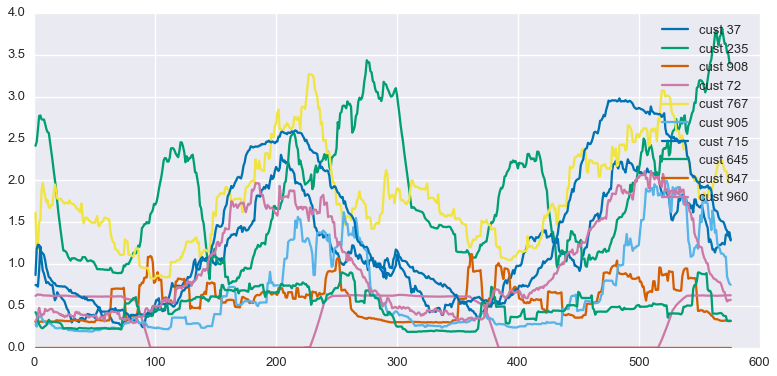

In [4]:
# check the real residential load 
H = 2*12*24+1; 

np.random.seed(1)
plt.figure(figsize=(13,6))
for j in np.random.randint(0, 1000, 10):
    plt.plot(range(1, H), res_load_df.iloc[j,1:].values, label="cust %d"%j)
    
plt.legend()    

In [5]:
solar_df = pd.read_pickle("../data/solar_data.pkl")
solar_cap = pd.read_csv("../data/solar_capacities.csv", header=None)

## Test on R1 case 

In [6]:
# pick solor site S16 
solar_data_1 = np.round(solar_df["S16"].values, 4)
solar_data_1_cap = solar_cap.iloc[16, 1]

In [7]:
# pick idx=960 customer 
res_load_1 = res_load_df.iloc[43, 1:]

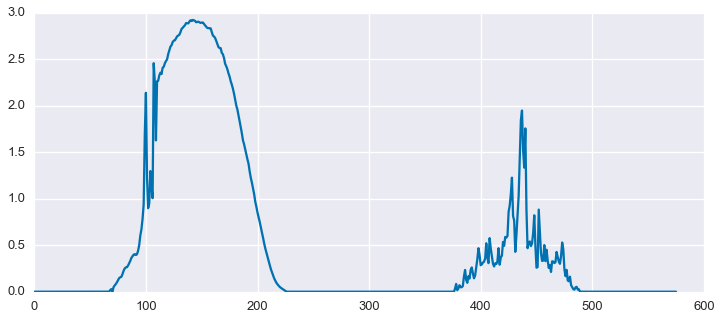

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(solar_data_1)

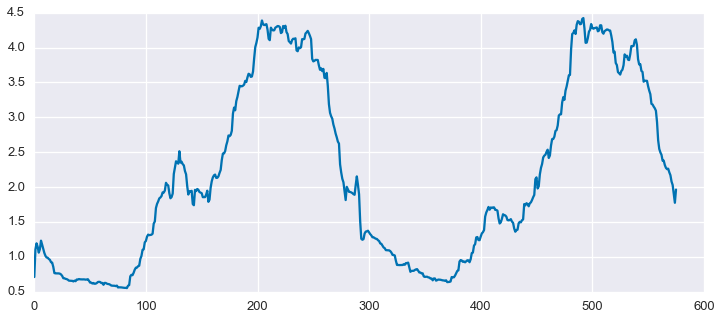

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(res_load_1.values)

In [10]:
def roundDigits(x, decimal_n=3):
    return np.round(x.values.tolist(), decimal_n)

In [11]:
agg_point = np.round(res_load_1.values.tolist(), decimals=3)

### without error diffusion 

Battery Capacity: 5


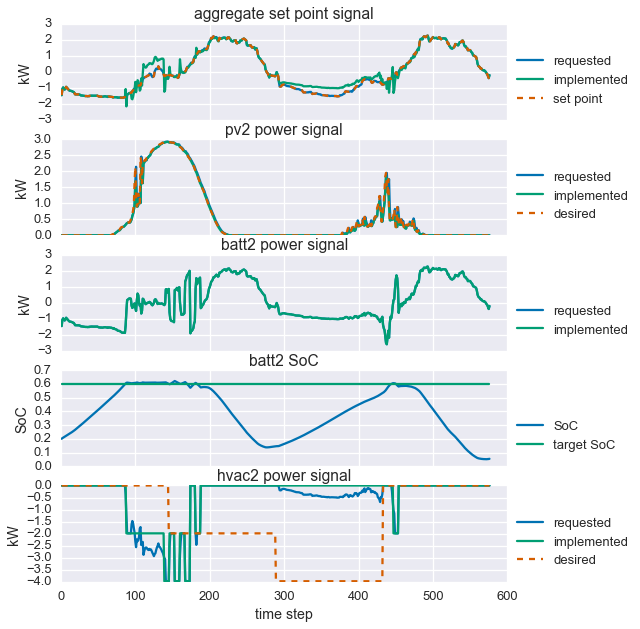

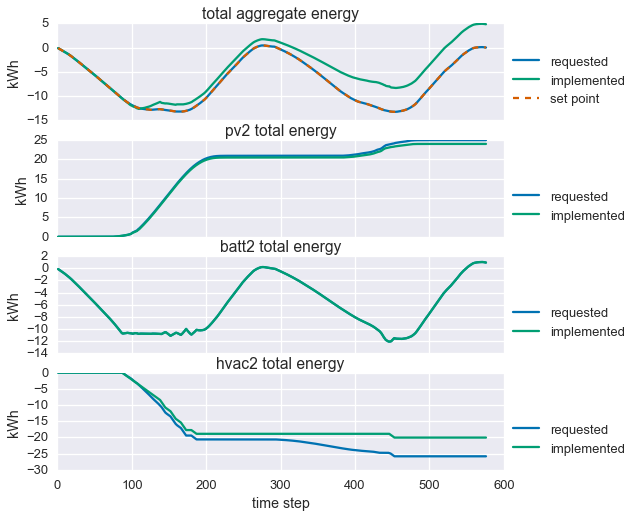

Battery Capacity: 10


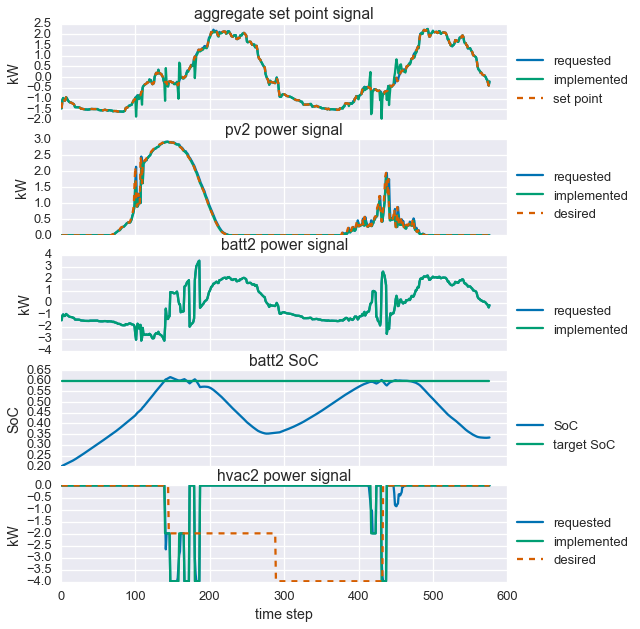

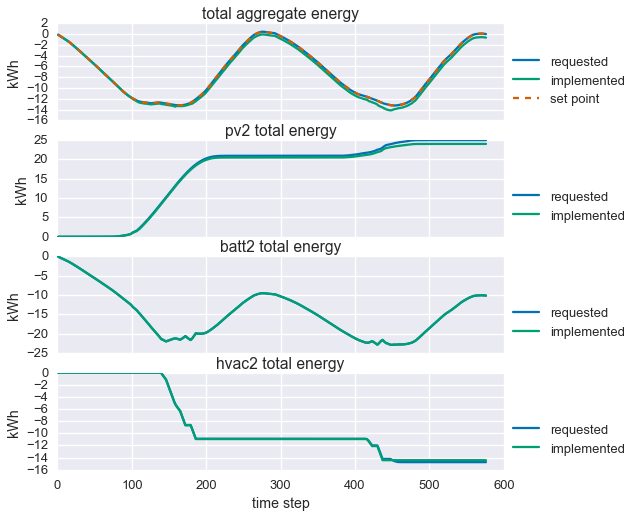

In [12]:
for cap in [5, 10]: # different battery size 
    print 'Battery Capacity:', cap
    controll_nondiffuse = Controller(mu=1e3)
    controll_nondiffuse.addResource(PVSys('pv2', data=np.r_[solar_data_1, 0], pmax=solar_data_1_cap))
    controll_nondiffuse.addResource(Battery('batt2', target_SoC=0.6, initial_SoC=0.2, Cb=1e-1, capacity=cap, pmin=-0.9*cap, pmax=0.9*cap, T=576))
    controll_nondiffuse.addResource(TCL('hvac2', Chvac=1e-1, pmax= -0.9*max(agg_point), T=576))
    controll_nondiffuse.runSimulation(agg_point-np.mean(agg_point), error_diffusion=False, solver='MOSEK')
    _ = controll_nondiffuse.plotReqImpPower()
    _ = controll_nondiffuse.plotReqImpTotalEnergy()
    plt.show()

### with error diffusion

Battery Capacity: 5


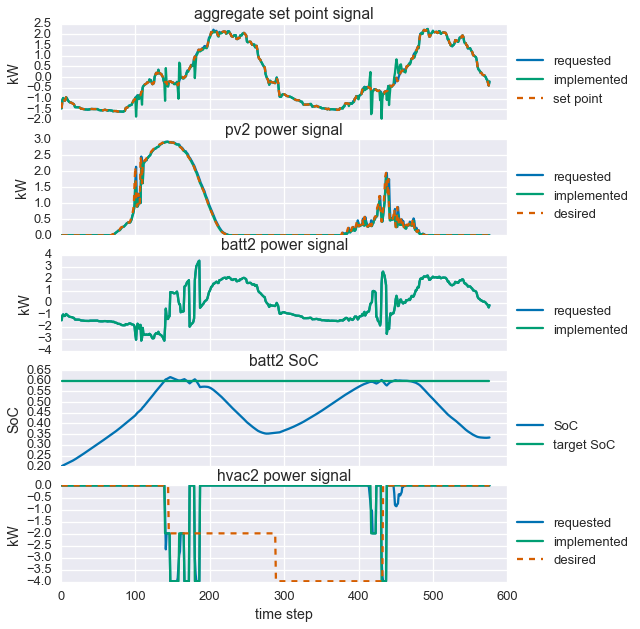

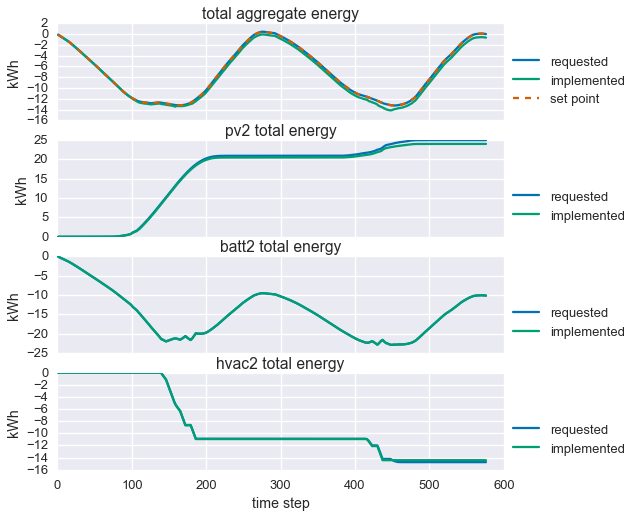

Battery Capacity: 10


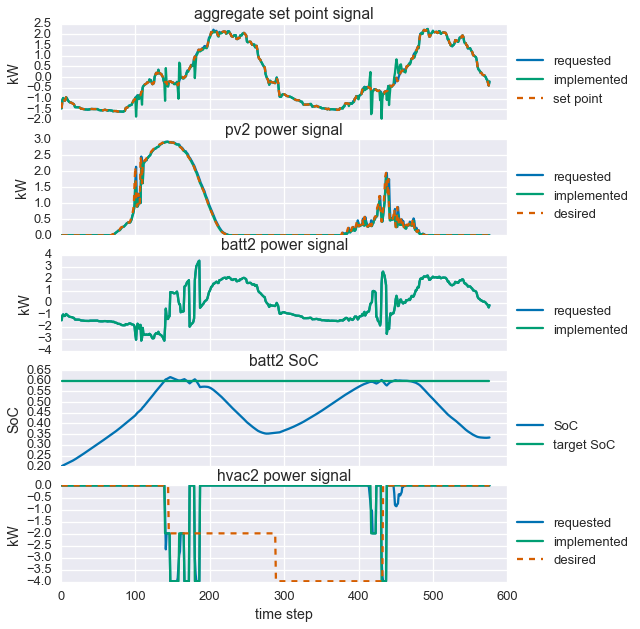

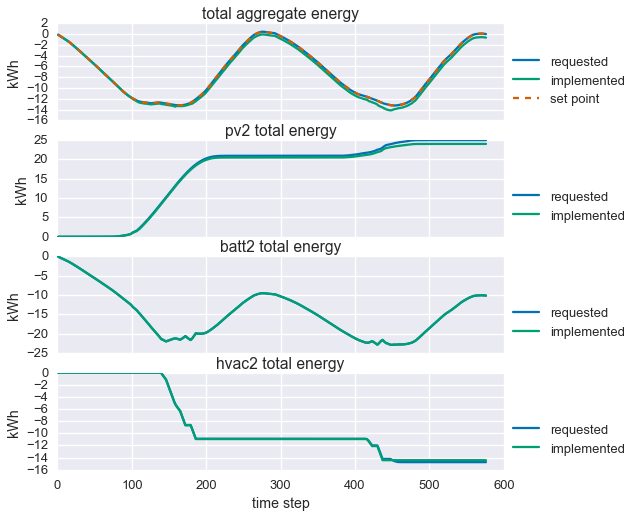

In [13]:
for cap in [5, 10]:
    print 'Battery Capacity:', cap
    controll_diffuse = Controller(mu=1e3)
    controll_diffuse.addResource(PVSys('pv2', data=np.r_[solar_data_1, 0], pmax=solar_data_1_cap, T=576))
    controll_diffuse.addResource(Battery('batt2', target_SoC=0.6, initial_SoC=0.2, Cb=1e-1, capacity=cap, pmin=-0.9*cap, pmax=0.9*cap, T=576))
    controll_diffuse.addResource(TCL('hvac2', Chvac=1e-1, pmax= -0.9*max(agg_point), T=576))
    controll_diffuse.runSimulation(agg_point-np.mean(agg_point), error_diffusion=True, solver='MOSEK')
    _ = controll_nondiffuse.plotReqImpPower()
    _ = controll_nondiffuse.plotReqImpTotalEnergy()
    plt.show()